In [20]:
!pip install pgmpy
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import BicScore, K2Score
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
import networkx as nx
from pgmpy.inference import VariableElimination, ApproxInference
import matplotlib.pyplot as plt
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from tabulate import tabulate
import itertools
import time



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
df = pd.read_csv("/content/drive/MyDrive/cleaning_dataset.csv")
df = df.drop(['Gender'],axis= 1)
print(df.shape)
df.head()

(1470, 13)


,Age,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,PerformanceRating,TotalWorkingYears,WorkLifeBalance
0,Senior,Yes,Rarely,Short,College,Rappresentative,Very_high,Single,On_average,Yes,Excellent,Competent,Bad
1,Senior,No,Frequently,Short,Below_college,Rappresentative,Medium,Married,On_average,No,Outstanding,Competent,Better
2,Middle-age,Yes,Rarely,Short,College,Technician,High,Single,Lower,Yes,Excellent,Competent,Better
3,Middle-age,No,Frequently,Short,Master,Technician,High,Married,Lower,Yes,Excellent,Competent,Better
4,Young,No,Rarely,Short,Below_college,Technician,Medium,Married,Lower,No,Excellent,Beginner,Better


# Hand-made net
The main idea is to follow a casual-effect order, in particular starting from the personal and job information of the employees to the effect of the jobs performed. In the network defined below the dipendencies relations are mostly defined by us because of the poor informatin the chi-square test gave us. 
The approch is summarized in the following points:

1.   Defining an order of the random variables
2.   Defining the edges 
3.   Building the net



# 1
from personal information of the employee such as: 'Age', 'Education' to the effect on the job 'OverTime' 'PerformanceRating' 'Attrition'..

In [22]:
orderd_list = ['Age','Education','MaritalStatus','DistanceFromHome','BusinessTravel',
               'WorkLifeBalance','TotalWorkingYears','JobLevel','OverTime','JobSatisfaction',
               'PerformanceRating','MonthlyIncome','Attrition']

# 2
The edges defined by us follow a general and intuitive approach of the employment domain

In [23]:
edges = [("Age","TotalWorkingYears"), 
         ("Age","JobLevel"), #dato dal chi square
         ("Education","JobLevel"),
         ("MaritalStatus","WorkLifeBalance"),
         ("MaritalStatus","BusinessTravel"),
         ("MaritalStatus","OverTime"),
         ("DistanceFromHome","WorkLifeBalance"),
         ("DistanceFromHome","JobSatisfaction"),
         ("WorkLifeBalance","Attrition"),
         ("BusinessTravel","OverTime"),
         ("BusinessTravel","WorkLifeBalance"),
         ("OverTime","MonthlyIncome"),
         ("OverTime","Attrition"),
         ("OverTime","PerformanceRating"),
         ("JobLevel","MonthlyIncome"),
         ("JobLevel","JobSatisfaction"),
         ("JobSatisfaction","PerformanceRating"),
         ("JobSatisfaction","Attrition"),
         ("TotalWorkingYears","JobLevel"),
         ("TotalWorkingYears","MonthlyIncome"),
         ("PerformanceRating","MonthlyIncome"),
         ]

# 3

Number of edges: 21


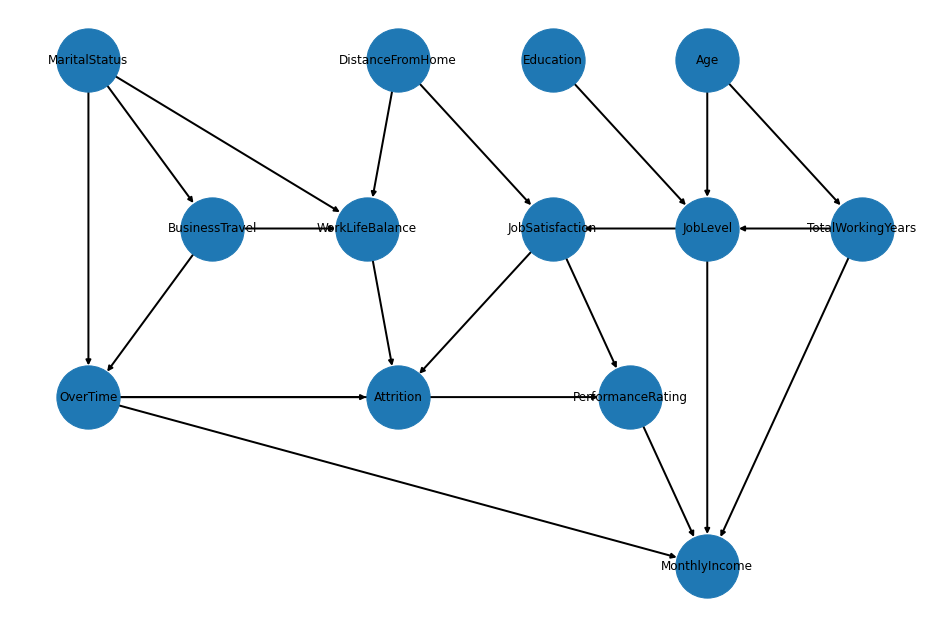

In [24]:
hand_net = BayesianNetwork(edges)
plt.figure(figsize=(13,8.5))
pos = {
     "MaritalStatus":(1,5),
     "DistanceFromHome":(3,5),
     "Education":(4,5),
     "Age":(5,5),
     "OverTime":(1,1),
     "BusinessTravel":(1.8,3),
     "WorkLifeBalance":(2.8,3),
     "JobSatisfaction":(4,3),
     "JobLevel":(5,3),
     "TotalWorkingYears":(6,3),
     "PerformanceRating":(4.5,1),
     "MonthlyIncome":(5,-1),
     "Attrition":(3,1),
}
print("Number of edges: " + str(len(edges)))
nx.draw(hand_net,pos=pos, with_labels=True, node_size=4000, width=2, arrowsize=10 )



# CPD's
## Byesian
The usage of bayesian estimator is due to the missing values that the Likelihood estimator computes as it's possible to observe in the structure learning network

In [30]:
hand_net.fit(df, estimator=BayesianEstimator)
cpds = hand_net.get_cpds()
for cpd in cpds:
    print(cpd)

+-----------------+----------+
| Age(Middle-age) | 0.422825 |
+-----------------+----------+
| Age(Senior)     | 0.355028 |
+-----------------+----------+
| Age(Young)      | 0.222147 |
+-----------------+----------+
+-------------------------------+-----+----------------------+
| Age                           | ... | Age(Young)           |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Beginner)   | ... | 0.47100712105798576  |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Competent)  | ... | 0.2726347914547304   |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Expert)     | ... | 0.001017293997965412 |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Novice)     | ... | 0.25432349949135297  |
+-------------------------------+-----+----------------------+
| TotalWorkingYears(Proficient) | ... | 0.001017293997965412 |
+--------------------------

# Number of parameters of the hand-made network

In [34]:
num_param = lambda model: sum([len(cpd.get_values().ravel()) for cpd in model.get_cpds()])
print('Number of parameters:',format(num_param(hand_net)))

Number of parameters: 832


# Active trail


In [44]:
def display_active_trails(network, target_node, given_nodes=[], nodes_position=pos):
    active_trail = network.active_trail_nodes(target_node, given_nodes)[target_node]

    #blue if target, pink if evidence, yellow if in trails active, red otherwise
    nodes_colors = []
    for node in network.nodes():
        if node == target_node:
            nodes_colors.append("tab:blue")
        elif node in given_nodes:
            nodes_colors.append("pink")
        elif node in active_trail:
            nodes_colors.append("yellow")
        else:
            nodes_colors.append("tab:red")

    # Same with edges, yellow if I have an active trail, red otherwise
    edges_colors = []
    edges_weights = []
    for (u, v) in network.edges:
        if u in active_trail and (v in active_trail or v in given_nodes):
            edges_colors.append("yellow")
            edges_weights.append(4)
        elif u in given_nodes and v == target_node:
            edges_colors.append("yellow")
            edges_weights.append(4)
        else:
            edges_colors.append("tab:red")
            edges_weights.append(2)

    # Finally I plot the network with colors
    plt.figure(figsize=(13,8.5))
    nx.draw(network, nodes_position, width=edges_weights,
            node_color=nodes_colors, edge_color=edges_colors,
            with_labels=True, node_size=4000, arrowsize=10)


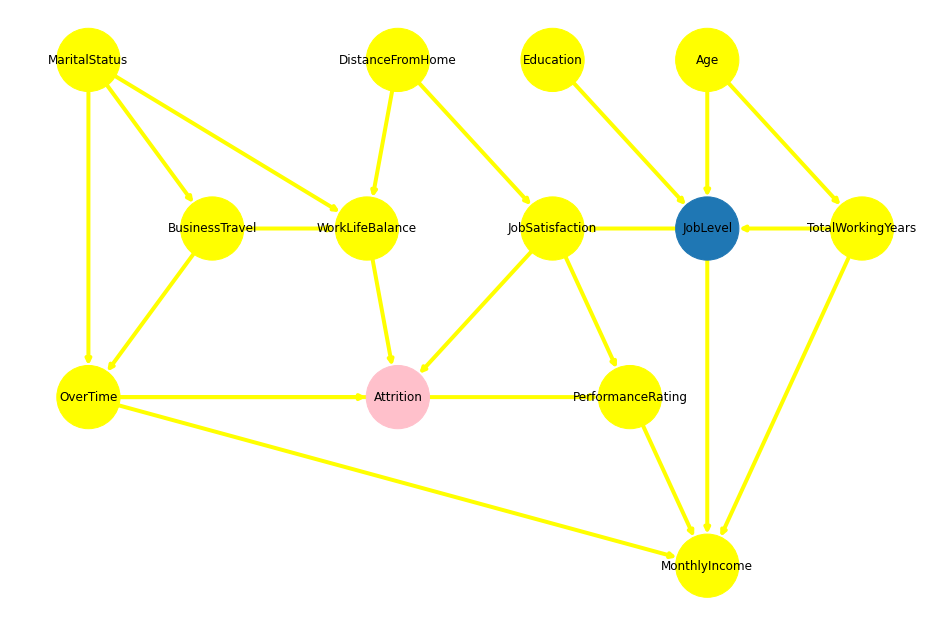

In [63]:
display_active_trails(hand_net, 'JobLevel',given_nodes =['Attrition'])

# Conditional Indipendence

In [48]:
def draw_indipendence(net,first_node,second_node,evidence = [], nodes_position=pos):
    ancenstors = []
    for ev in evidence:
        ancenstors.append(net._get_ancestors_of(ev))
    
    ancestors = set().union(*ancenstors)
    nodes_colors = []
    for node in net.nodes():
        if node == first_node or node == second_node:
            nodes_colors.append("blue")
        elif node in evidence:
            nodes_colors.append("red")
        elif node in ancestors:
            nodes_colors.append("yellow")
        else:
            nodes_colors.append("green")
    
    plt.figure(figsize=(13,8.5))
    nx.draw(net, nodes_position, node_color=nodes_colors,with_labels=True, node_size=4000, arrowsize=10)

def is_indipendent(net,first_node,second_node,evidence = []):
    active_trail = net.active_trail_nodes(first_node,evidence)[first_node]
    if second_node in active_trail:
        return 'Dipendent'
    return 'Indipendent'

'Dipendent'

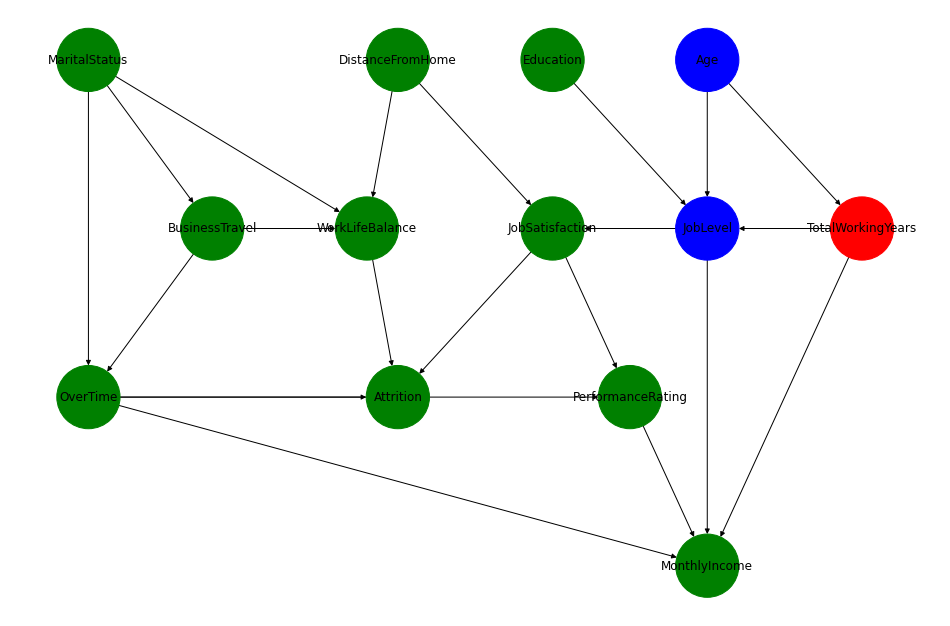

In [52]:
draw_indipendence(hand_net,'Age','JobLevel',evidence = ['TotalWorkingYears'])
is_indipendent(hand_net,'Age','JobLevel',evidence = ['TotalWorkingYears'])

'Dipendent'

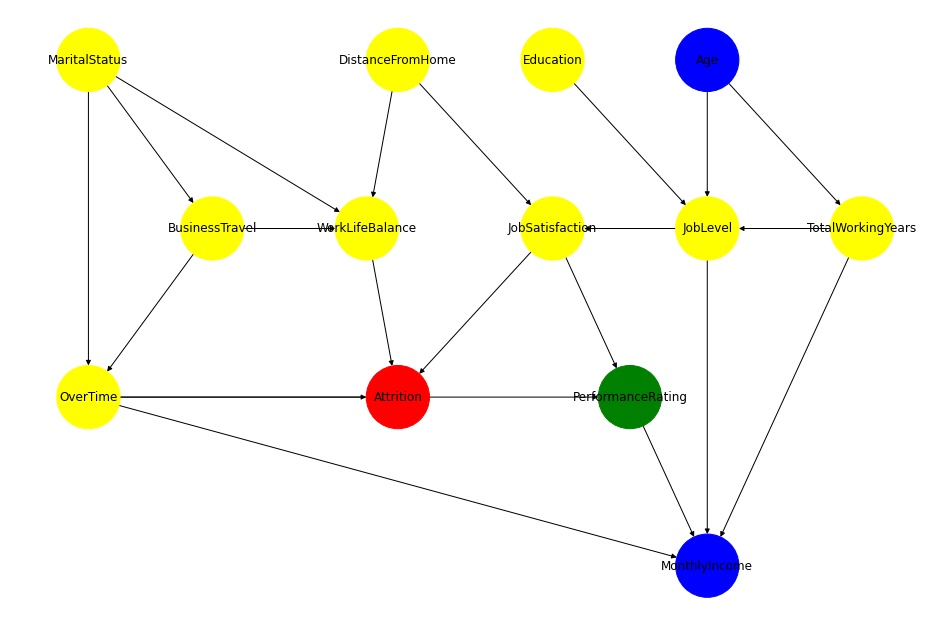

In [54]:
draw_indipendence(hand_net,'Age','MonthlyIncome',evidence = ['Attrition'])
is_indipendent(hand_net,'Age','MonthlyIncome',evidence = ['Attrition'])

'Indipendent'

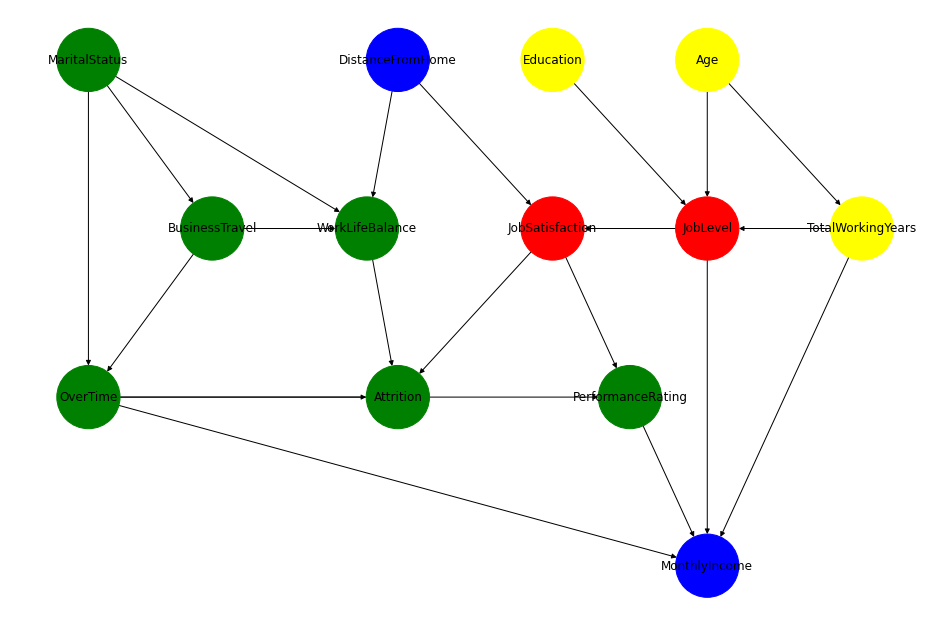

In [56]:
draw_indipendence(hand_net,'MonthlyIncome','DistanceFromHome',evidence = ['JobSatisfaction','JobLevel'])
is_indipendent(hand_net,'MonthlyIncome','DistanceFromHome',evidence = ['JobSatisfaction','JobLevel'])



'Dipendent'

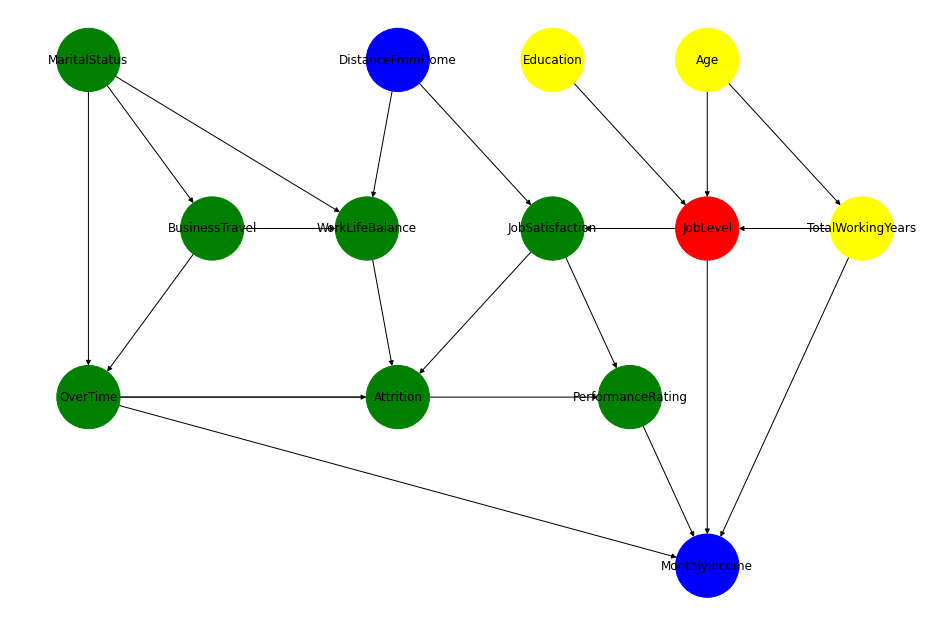

In [58]:
draw_indipendence(hand_net,'MonthlyIncome','DistanceFromHome',evidence = ['JobLevel'])
is_indipendent(hand_net,'MonthlyIncome','DistanceFromHome',evidence = ['JobLevel'])

'Dipendent'

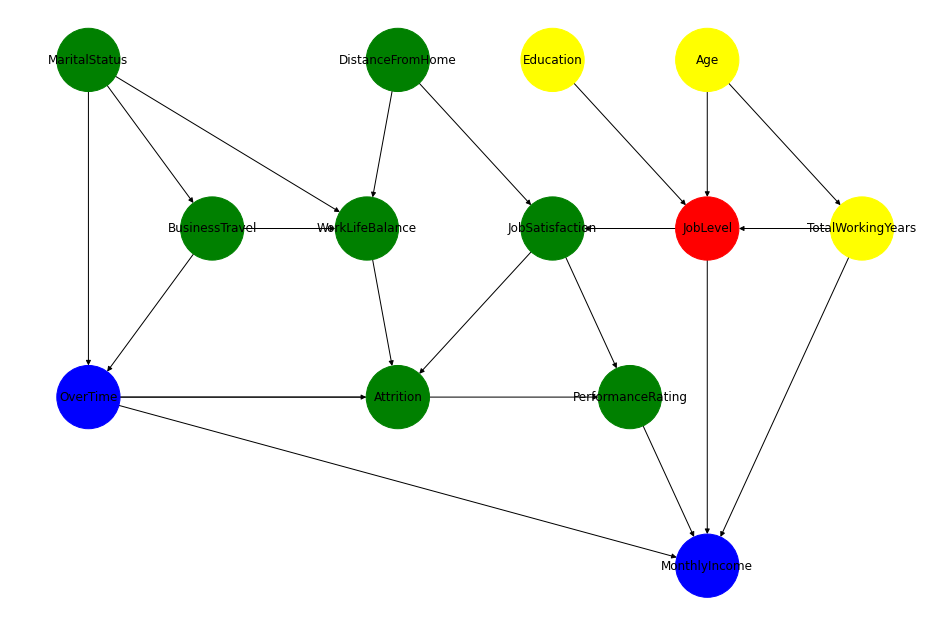

In [57]:
draw_indipendence(hand_net, 'MonthlyIncome', 'OverTime',['JobLevel'])
is_indipendent(hand_net, 'MonthlyIncome', 'OverTime',['JobLevel'])

# Exact inference with Bayesian Estimator


In [59]:
infer = VariableElimination(hand_net)
print(infer.query(['TotalWorkingYears'], evidence={'Age':'Young'}))

+-------------------------------+--------------------------+
| TotalWorkingYears             |   phi(TotalWorkingYears) |
+===============================+==========================+
| TotalWorkingYears(Beginner)   |                   0.4710 |
+-------------------------------+--------------------------+
| TotalWorkingYears(Competent)  |                   0.2726 |
+-------------------------------+--------------------------+
| TotalWorkingYears(Expert)     |                   0.0010 |
+-------------------------------+--------------------------+
| TotalWorkingYears(Novice)     |                   0.2543 |
+-------------------------------+--------------------------+
| TotalWorkingYears(Proficient) |                   0.0010 |
+-------------------------------+--------------------------+


In [60]:
print(infer.query(['MonthlyIncome'], evidence={'JobLevel':'Rappresentative'}))
print(infer.query(['MonthlyIncome'], evidence={'JobLevel':'Manager'}))



+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.1878 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.0455 |
+---------------------------+----------------------+
| MonthlyIncome(On_average) |               0.7667 |
+---------------------------+----------------------+
+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.9831 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.0085 |
+---------------------------+----------------------+
| MonthlyIncome(On_average) |               0.0085 |
+---------------------------+----------------------+


In [61]:
print(infer.query(['MonthlyIncome'], evidence={'PerformanceRating':'Excellent','OverTime': 'Yes'}))
print(infer.query(['Attrition'], evidence={'PerformanceRating':'Excellent','OverTime': 'Yes'}))

+---------------------------+----------------------+
| MonthlyIncome             |   phi(MonthlyIncome) |
+===========================+======================+
| MonthlyIncome(Higher)     |               0.3294 |
+---------------------------+----------------------+
| MonthlyIncome(Lower)      |               0.3308 |
+---------------------------+----------------------+
| MonthlyIncome(On_average) |               0.3399 |
+---------------------------+----------------------+
+----------------+------------------+
| Attrition      |   phi(Attrition) |
+================+==================+
| Attrition(No)  |           0.6846 |
+----------------+------------------+
| Attrition(Yes) |           0.3154 |
+----------------+------------------+


In [62]:
print(infer.query(['JobSatisfaction'], evidence={'DistanceFromHome':'Short','WorkLifeBalance': 'Best'}))

+----------------------------+------------------------+
| JobSatisfaction            |   phi(JobSatisfaction) |
+============================+========================+
| JobSatisfaction(High)      |                 0.2934 |
+----------------------------+------------------------+
| JobSatisfaction(Low)       |                 0.1966 |
+----------------------------+------------------------+
| JobSatisfaction(Medium)    |                 0.1950 |
+----------------------------+------------------------+
| JobSatisfaction(Very_high) |                 0.3150 |
+----------------------------+------------------------+
